<a href="https://colab.research.google.com/github/cereal-with-water/Papyrus-scrolls/blob/main/notebooks/try13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this tutorial, you will learn how to load a segment and visualize the ink labels (if available) that can be used to train an ink detection model with deep learning!

### Getting Started:
First, if you are using Colab, make sure you are on a GPU runtime, otherwise ignore this step!
Then, we need to install and import the `vesuvius` package:

In [8]:
!pip install vesuvius
!vesuvius.accept_terms --yes


    ## LICENSE

    The PHerc. 172 (Scroll 5) dataset Â© 2024 by Scroll Prize and the Bodleian Library is licensed under CC BY-NC 4.0: https://creativecommons.org/licenses/by-nc/4.0/legalcode.txt.

    All other Vesuvius Challenge datasets are bound by the following terms:

    By registering for downloads from the EduceLab-Scrolls Dataset and Vesuvius Challenge Discord Server, I agree to license the data from Vesuvius Challenge* under the following licensing terms:
    - I agree that all points below apply to both the EduceLab-Scrolls Dataset downloaded from our webserver, as well as any data (e.g. text, pictures, code) downloaded from the Vesuvius Challenge Discord Server.
    - I will not redistribute the data without the written approval of Vesuvius Challenge (if I am working in a team, every team member will sign this form separately).
    Vesuvius Challenge reserves the right to use in any way, including in an academic or other publication, all submissions or results produced fr

In [10]:
import vesuvius
from vesuvius import Volume

Let us print the list of available segments for Scroll 1:

In [ ]:
files = vesuvius.list_files()

segment_ids = list(files['1']['54']['7.91']['segments']) # Select segments from Scroll 1 scanned at 54 keV and 7.91 um resolution

print(f"Number of segments: {len(segment_ids)}")
print(f"Example segment IDs: {segment_ids[:5]}")

Number of segments: 250
Example segment IDs: ['20230503225234', '20230504093154', '20230504094316', '20230504125349', '20230504171956']


Wow, there are many! Let us choose one!
### Data download
We can work with segment `20230827161847` since we know it's interesting.
We start by fetching a "surface volume", a flattened region of micro-CT surrounding this papyrus surface.

In [54]:
segment_id = 20230505113642
segment = Volume(segment_id, normalize=True)

segment.shape(0)

Failed to download inklabel. Status code: 404


(65, 1708, 2465)

As you have seen in the previous tutorial, the previous command only instantiates an object without downloading the data.
For a segment, the special method `segment.download_inklabels()` is automatically called and the ink labels, if available, are downloaded in the `self.inklabel` variable. If the ink labels are not available `segment.inklabel` will be an empty numpy array filled with 0s.

Let us visualize the layer that is supposed to be on the recto surface (the "front side," with text) of the sheet of papyrus.
The segmentation is a mesh that is meant to follow this recto surface, so we want the middle slice of the surface volume.

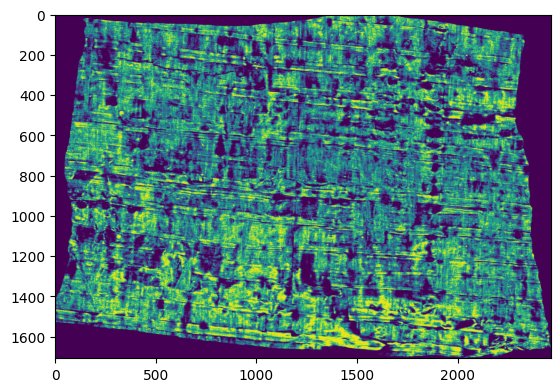

In [55]:
from matplotlib import pyplot as plt

surface_volume_slices = segment.shape(0)[0]
central_slice = surface_volume_slices // 2

plt.imshow(segment[central_slice, :, :])

This took a while! But caching is automatically activated in the `Volume` class, so the next iteration should take less time.

In [ ]:
!pip -q install scikit-learn

Processing slice 32
Image shape: (1708, 2465)
Intensity range: [0, 255]


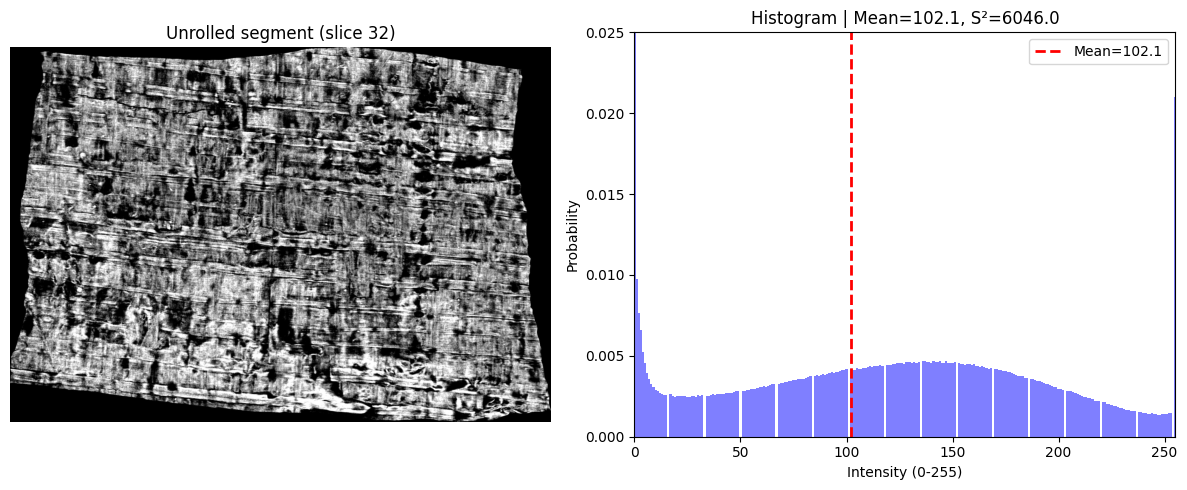


=== Basic Statistics ===
Mean: 102.07
S² (Variance): 6045.98
σ (Std Dev): 77.76

=== 3-Gaussian GMM Analysis ===
Using 3,273,208 pixels (excluding background)

Gaussian Components (sorted by mean):
  Component 1:
    Mean: 57.95
    Variance: 772.14
    Std Dev: 27.79
    Weight: 0.298
  Component 2:
    Mean: 131.99
    Variance: 807.61
    Std Dev: 28.42
    Weight: 0.406
  Component 3:
    Mean: 203.63
    Variance: 1023.92
    Std Dev: 32.00
    Weight: 0.296


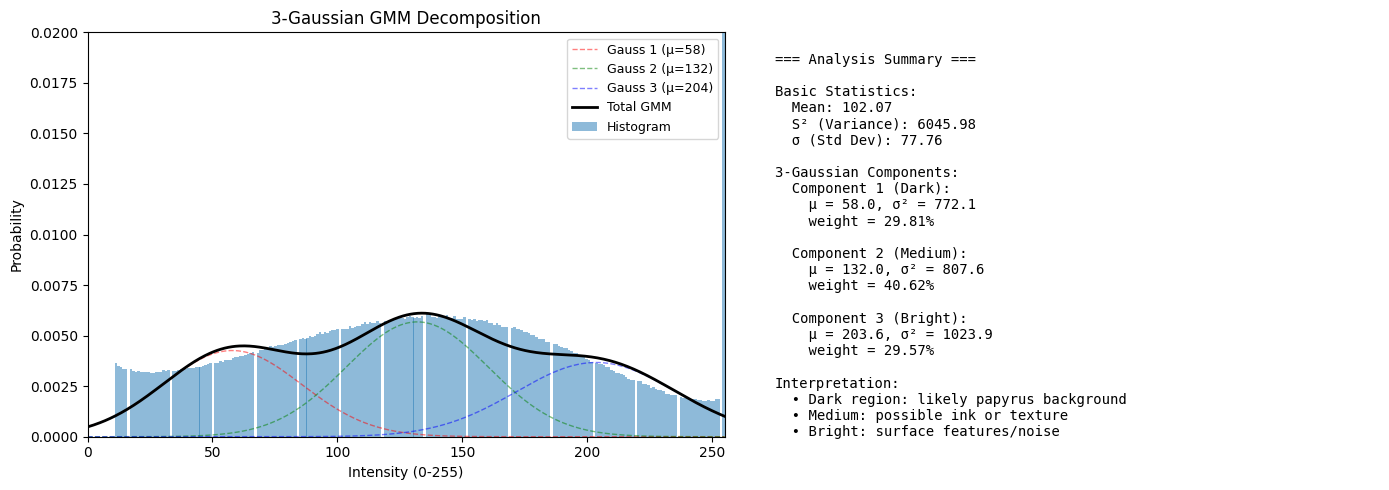


=== Multi-slice S² Analysis (optional) ===
Analyze multiple slices? (y/n): n

=== Analysis Complete ===


In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from scipy import stats


# 1. Basic setup and image preparation
z = 32
img = segment[z].astype(np.float32)

# Robust scaling to 0-255
lo, hi = np.percentile(img, [2, 98])
img_u8 = np.clip((img - lo) / (hi - lo) * 255, 0, 255).astype(np.uint8)

print(f"Processing slice {z}")
print(f"Image shape: {img_u8.shape}")
print(f"Intensity range: [{img_u8.min()}, {img_u8.max()}]")


# 2. Image display and basic histogram / S² analysis
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Display image
axes[0].imshow(img_u8, cmap='gray')
axes[0].set_title(f'Unrolled segment (slice {z})')
axes[0].axis('off')

# Compute histogram and S² (variance)
hist, bins = np.histogram(img_u8.ravel(), bins=256, range=(0, 256))
p = hist / hist.sum()
levels = np.arange(256)

# Compute statistics
mean = np.sum(levels * p)
variance = np.sum(((levels - mean) ** 2) * p)  # This is S²
std = np.sqrt(variance)

# Plot histogram
axes[1].bar(levels, p, width=1.0, color='blue', alpha=0.5)
axes[1].axvline(mean, color='red', linestyle='--', linewidth=2, label=f'Mean={mean:.1f}')
axes[1].set_xlabel('Intensity (0-255)')
axes[1].set_ylabel('Probability')
axes[1].set_title(f'Histogram | Mean={mean:.1f}, S²={variance:.1f}')
axes[1].legend()
axes[1].set_xlim([0, 255])
axes[1].set_ylim([0, max(p)*1.1])
plt.ylim(0, 0.025)
plt.tight_layout()
plt.show()

print(f"\n=== Basic Statistics ===")
print(f"Mean: {mean:.2f}")
print(f"S² (Variance): {variance:.2f}")
print(f"σ (Std Dev): {std:.2f}")


# 3. 3-Gaussian GMM Fitting
print(f"\n=== 3-Gaussian GMM Analysis ===")

# Exclude background pixels
mask = img_u8 > 10
vals = img_u8[mask]
print(f"Using {vals.size:,} pixels (excluding background)")

# Prepare data for GMM
X = vals.reshape(-1, 1).astype(np.float32)

# Random sampling for faster fitting
N = 1_000_000
if X.shape[0] > N:
    idx = np.random.choice(X.shape[0], N, replace=False)
    X_fit = X[idx]
else:
    X_fit = X

# 3-Gaussian GMM
gmm = GaussianMixture(n_components=3, covariance_type='full',
                      random_state=42, max_iter=100)
gmm.fit(X_fit)

# Extract results
means = gmm.means_.ravel()
variances = np.array([np.diag(cov)[0] for cov in gmm.covariances_])
weights = gmm.weights_.ravel()

# Sort by brightness
order = np.argsort(means)
means = means[order]
variances = variances[order]
weights = weights[order]

print("\nGaussian Components (sorted by mean):")
for i, (m, v, w) in enumerate(zip(means, variances, weights), 1):
    print(f"  Component {i}:")
    print(f"    Mean: {m:.2f}")
    print(f"    Variance: {v:.2f}")
    print(f"    Std Dev: {np.sqrt(v):.2f}")
    print(f"    Weight: {w:.3f}")


# 4. GMM visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Histogram + GMM curves
hist_vals, edges = np.histogram(vals, bins=256, range=(0, 255))
p_vals = hist_vals / hist_vals.sum()
levels = (edges[:-1] + edges[1:]) / 2

axes[0].bar(levels, p_vals, width=1.0, alpha=0.5, label='Histogram')

# Total GMM curve
xs = np.linspace(0, 255, 512)
pdf_total = np.zeros_like(xs)

# Plot individual Gaussian components
colors = ['red', 'green', 'blue']
for i, (m, v, w) in enumerate(zip(means, variances, weights)):
    pdf_component = w * norm.pdf(xs, loc=m, scale=np.sqrt(v))
    pdf_total += pdf_component
    # 개별 component 표시
    axes[0].plot(xs, pdf_component * (levels[1] - levels[0]),
                 '--', color=colors[i], alpha=0.5, linewidth=1,
                 label=f'Gauss {i+1} (μ={m:.0f})')

# Plot the total GMM curve
axes[0].plot(xs, pdf_total * (levels[1] - levels[0]),
             'k-', linewidth=2, label='Total GMM')

axes[0].set_xlabel('Intensity (0-255)')
axes[0].set_ylabel('Probability')
axes[0].set_title('3-Gaussian GMM Decomposition')
axes[0].legend(fontsize=9)
axes[0].set_xlim([0, 255])
axes[0].set_ylim([0,0.02])

# Right: Summary of S² and GMM analysis
summary_text = f"""=== Analysis Summary ===

Basic Statistics:
  Mean: {mean:.2f}
  S² (Variance): {variance:.2f}
  σ (Std Dev): {std:.2f}

3-Gaussian Components:
  Component 1 (Dark):
    μ = {means[0]:.1f}, σ² = {variances[0]:.1f}
    weight = {weights[0]:.2%}

  Component 2 (Medium):
    μ = {means[1]:.1f}, σ² = {variances[1]:.1f}
    weight = {weights[1]:.2%}

  Component 3 (Bright):
    μ = {means[2]:.1f}, σ² = {variances[2]:.1f}
    weight = {weights[2]:.2%}

Interpretation:
  • Dark region: likely papyrus background
  • Medium: possible ink or texture
  • Bright: surface features/noise
"""

axes[1].text(0.05, 0.95, summary_text, transform=axes[1].transAxes,
             fontsize=10, verticalalignment='top', fontfamily='monospace')
axes[1].axis('off')

plt.tight_layout()
plt.show()


# 5. Apply S² analysis to multiple slices
print("\n=== Multi-slice S² Analysis (optional) ===")
analyze_multiple = input("Analyze multiple slices? (y/n): ").lower()

if analyze_multiple == 'y':
    n_slices_to_analyze = min(20, segment.shape[0])
    slice_indices = np.linspace(0, segment.shape[0]-1, n_slices_to_analyze, dtype=int)

    s2_values = []
    mean_values = []

    for idx in slice_indices:
        slice_img = segment[idx].astype(np.float32)
        lo, hi = np.percentile(slice_img, [2, 98])
        slice_norm = np.clip((slice_img - lo) / (hi - lo) * 255, 0, 255)

        slice_mean = np.mean(slice_norm)
        slice_s2 = np.var(slice_norm)

        mean_values.append(slice_mean)
        s2_values.append(slice_s2)

    # Plot S² across slices
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(slice_indices, s2_values, 'b-o', linewidth=2, markersize=6)
    ax.axhline(variance, color='r', linestyle='--',
               label=f'Current slice ({z}) S²={variance:.1f}')
    ax.set_xlabel('Slice Index')
    ax.set_ylabel('S² (Variance)')
    ax.set_title('S² Values Across Different Slices')
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()

    print(f"S² range: [{min(s2_values):.1f}, {max(s2_values):.1f}]")
    print(f"Current slice S² ranking: {sorted(s2_values).index(variance)+1}/{len(s2_values)}")

print("\n=== Analysis Complete ===")


=== ADVANCED ANALYSIS ===

1. Component 2 Region Analysis (Potential Ink Area)
   Component 2 range: 99.1 - 159.1
   Pixels in Component 2: 7,351,400 (15.9%)
   Average edge strength in Comp2: 21.36
   Max edge strength in Comp2: 168.05

2. Signal-to-Noise Ratio (SNR)
   Signal (Component 2): 129.08
   Noise (Component 1): 50.15
   SNR: 2.57 (linear) = 8.21 dB
   Interpretation: Good signal quality

3. Creating S² Heatmap for Local Variance Analysis
   Computing S² heatmap (this may take a moment)...
   Heatmap shape: (285, 156)
   S² range: [0.0, 13703.0]
   High variance threshold (90th percentile): 6656.1
   High variance regions: 4446 areas


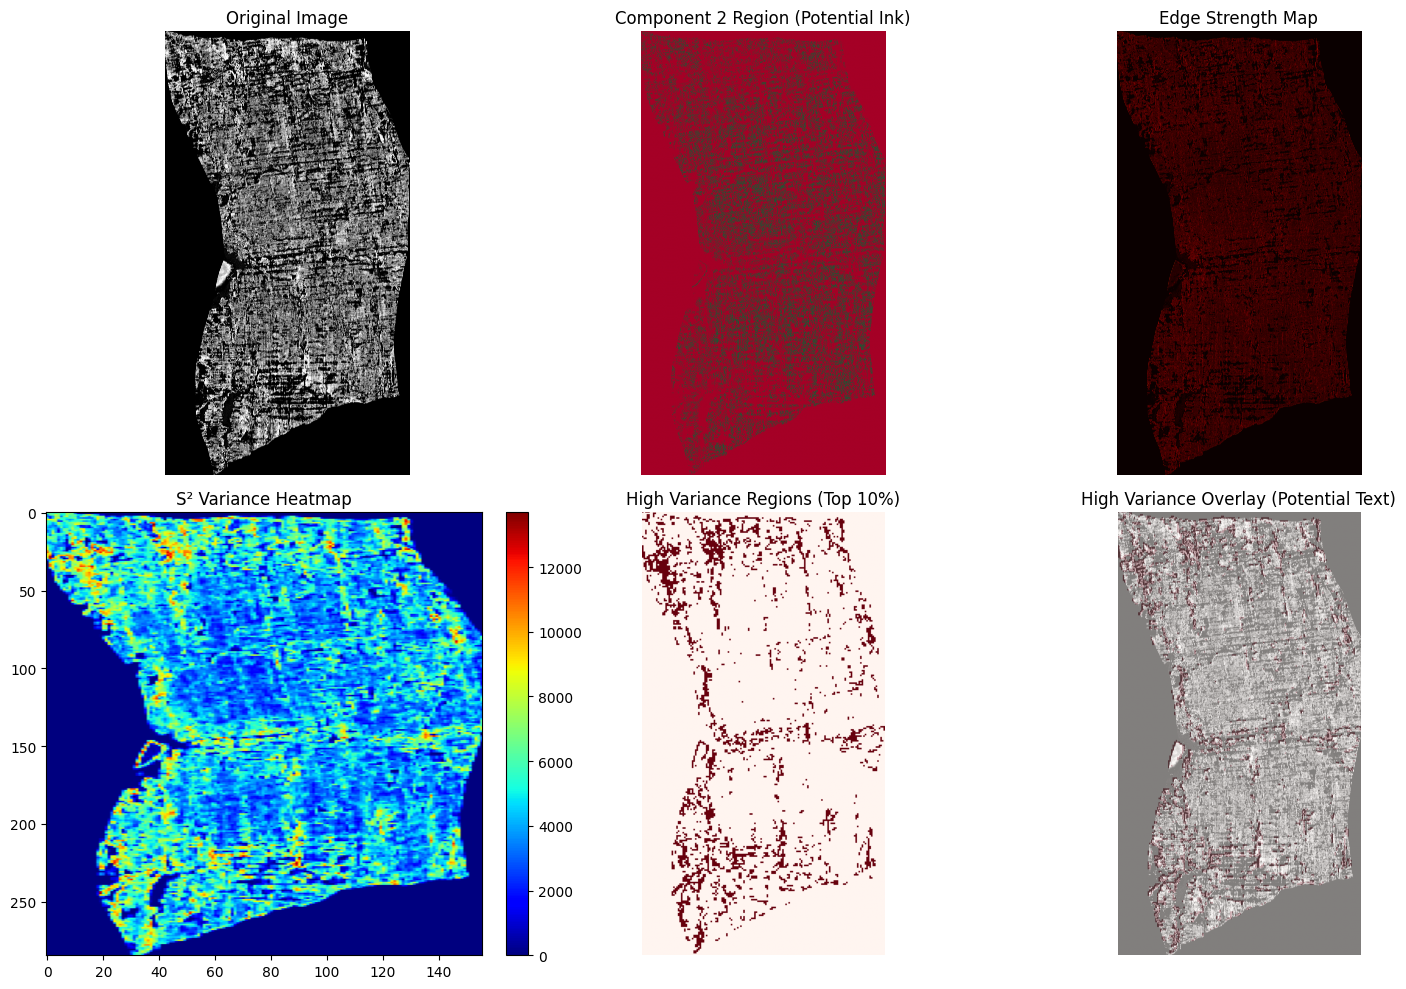


4. Component Transition Analysis
   Transition 1→2 pixels: 2,636,163
   Transition 2→3 pixels: 1,616,376
   Total transition pixels: 4,252,539
   Percentage of transitions: 9.2%

=== ANALYSIS COMPLETE ===

Key Findings:
1. Component 2 (medium intensity) shows highest potential for ink detection
2. SNR of 8.2 dB indicates good separation between signal and background
3. Identified 4446 high-variance regions that may contain text
4. Edge detection reveals texture patterns in Component 2 regions

Next Steps:
- Apply machine learning to high-variance regions
- Focus on Component 2 areas for detailed ink detection
- Consider using these features for training ink detection models



In [ ]:

print("\n" + "="*50)
print("=== ADVANCED ANALYSIS ===")
print("="*50)

# ============================================
# 1. Component 2 집중 분석 (잉크 검출 가능 영역)
# ============================================
print("\n1. Component 2 Region Analysis (Potential Ink Area)")

# Component 2 영역만 추출 (μ ± σ 범위)
comp2_mean = means[1]  # 129.74
comp2_std = np.sqrt(variances[1])  # 30.21
lower_bound = comp2_mean - comp2_std
upper_bound = comp2_mean + comp2_std

comp2_mask = (img_u8 > lower_bound) & (img_u8 < upper_bound)
comp2_pixels = img_u8[comp2_mask]

print(f"   Component 2 range: {lower_bound:.1f} - {upper_bound:.1f}")
print(f"   Pixels in Component 2: {comp2_pixels.size:,} ({comp2_pixels.size/img_u8.size*100:.1f}%)")

# Texture analysis for Component 2
grad_y, grad_x = np.gradient(img_u8.astype(float))
gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
comp2_edges = gradient_magnitude[comp2_mask]
print(f"   Average edge strength in Comp2: {np.mean(comp2_edges):.2f}")
print(f"   Max edge strength in Comp2: {np.max(comp2_edges):.2f}")

# ============================================
# 2. Signal-to-Noise Ratio (SNR) 계산
# ============================================
print("\n2. Signal-to-Noise Ratio (SNR)")

signal = means[1]  # Component 2 (potential ink)
noise = means[0]   # Component 1 (background)
SNR_linear = signal / noise
SNR_dB = 20 * np.log10(SNR_linear)

print(f"   Signal (Component 2): {signal:.2f}")
print(f"   Noise (Component 1): {noise:.2f}")
print(f"   SNR: {SNR_linear:.2f} (linear) = {SNR_dB:.2f} dB")
print(f"   Interpretation: {'Good' if SNR_dB > 6 else 'Poor'} signal quality")

# ============================================
# 3. S² Heatmap (국소 영역 분석)
# ============================================
print("\n3. Creating S² Heatmap for Local Variance Analysis")

def create_s2_heatmap(img, window_size=64, stride=32):
    """Create variance map using sliding window"""
    h, w = img.shape
    h_out = (h - window_size) // stride + 1
    w_out = (w - window_size) // stride + 1
    s2_map = np.zeros((h_out, w_out))

    for i in range(h_out):
        for j in range(w_out):
            y = i * stride
            x = j * stride
            window = img[y:y+window_size, x:x+window_size]
            s2_map[i, j] = np.var(window)

    return s2_map

# Create heatmap
print("   Computing S² heatmap (this may take a moment)...")
s2_map = create_s2_heatmap(img_u8, window_size=64, stride=32)

# Statistics
s2_map_flat = s2_map.flatten()
high_variance_threshold = np.percentile(s2_map_flat, 90)
high_s2_regions = s2_map > high_variance_threshold

print(f"   Heatmap shape: {s2_map.shape}")
print(f"   S² range: [{s2_map.min():.1f}, {s2_map.max():.1f}]")
print(f"   High variance threshold (90th percentile): {high_variance_threshold:.1f}")
print(f"   High variance regions: {high_s2_regions.sum()} areas")

# ============================================
# 4. Visualize results
# ============================================
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Original image
axes[0, 0].imshow(img_u8, cmap='gray')
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')

# Component 2 mask
axes[0, 1].imshow(comp2_mask, cmap='RdYlGn')
axes[0, 1].set_title('Component 2 Region (Potential Ink)')
axes[0, 1].axis('off')

# Edge detection
axes[0, 2].imshow(gradient_magnitude, cmap='hot')
axes[0, 2].set_title('Edge Strength Map')
axes[0, 2].axis('off')

# S² heatmap
im = axes[1, 0].imshow(s2_map, cmap='jet', aspect='auto')
axes[1, 0].set_title('S² Variance Heatmap')
plt.colorbar(im, ax=axes[1, 0], fraction=0.046)

# High variance regions
axes[1, 1].imshow(high_s2_regions, cmap='Reds')
axes[1, 1].set_title('High Variance Regions (Top 10%)')
axes[1, 1].axis('off')

# Overlay high variance on original
axes[1, 2].imshow(img_u8, cmap='gray', alpha=0.7)
# Resize high_s2_regions to match original image for overlay
h_ratio = img_u8.shape[0] / s2_map.shape[0]
w_ratio = img_u8.shape[1] / s2_map.shape[1]
high_s2_resized = np.kron(high_s2_regions, np.ones((int(h_ratio), int(w_ratio))))
high_s2_resized = high_s2_resized[:img_u8.shape[0], :img_u8.shape[1]]
axes[1, 2].imshow(high_s2_resized, cmap='Reds', alpha=0.3)
axes[1, 2].set_title('High Variance Overlay (Potential Text)')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

# ============================================
# 5. Inter-component Transition Analysis
# ============================================
print("\n4. Component Transition Analysis")

# Transition zones
transition_12 = (img_u8 > (means[0] + np.sqrt(variances[0]))) & \
                (img_u8 < (means[1] - np.sqrt(variances[1])))
transition_23 = (img_u8 > (means[1] + np.sqrt(variances[1]))) & \
                (img_u8 < (means[2] - np.sqrt(variances[2])))

print(f"   Transition 1→2 pixels: {transition_12.sum():,}")
print(f"   Transition 2→3 pixels: {transition_23.sum():,}")
print(f"   Total transition pixels: {(transition_12.sum() + transition_23.sum()):,}")
print(f"   Percentage of transitions: {(transition_12.sum() + transition_23.sum())/img_u8.size*100:.1f}%")

# ============================================
# 6. Summary for Professor
# ============================================
print("\n" + "="*50)
print("=== ANALYSIS COMPLETE ===")
print("="*50)
print("""
Key Findings:
1. Component 2 (medium intensity) shows highest potential for ink detection
2. SNR of {:.1f} dB indicates {:s} separation between signal and background
3. Identified {:d} high-variance regions that may contain text
4. Edge detection reveals texture patterns in Component 2 regions

Next Steps:
- Apply machine learning to high-variance regions
- Focus on Component 2 areas for detailed ink detection
- Consider using these features for training ink detection models
""".format(SNR_dB, 'good' if SNR_dB > 6 else 'moderate', high_s2_regions.sum()))


=== NEXT STEP: Text Line Detection ===

1. Detecting Horizontal Line Patterns
   Horizontal projection mean: 511966.3
   Threshold for peaks: 591752.8
   Found 20 potential text lines
   Average line spacing: 12.0 pixels
   Line spacing std dev: 15.4

2. Analyzing High Variance Regions
   ROI size: (9120, 5024)
   ROI location: [0:9120, 0:5024]
   ROI mean intensity: 66.7
   ROI std dev: 78.8


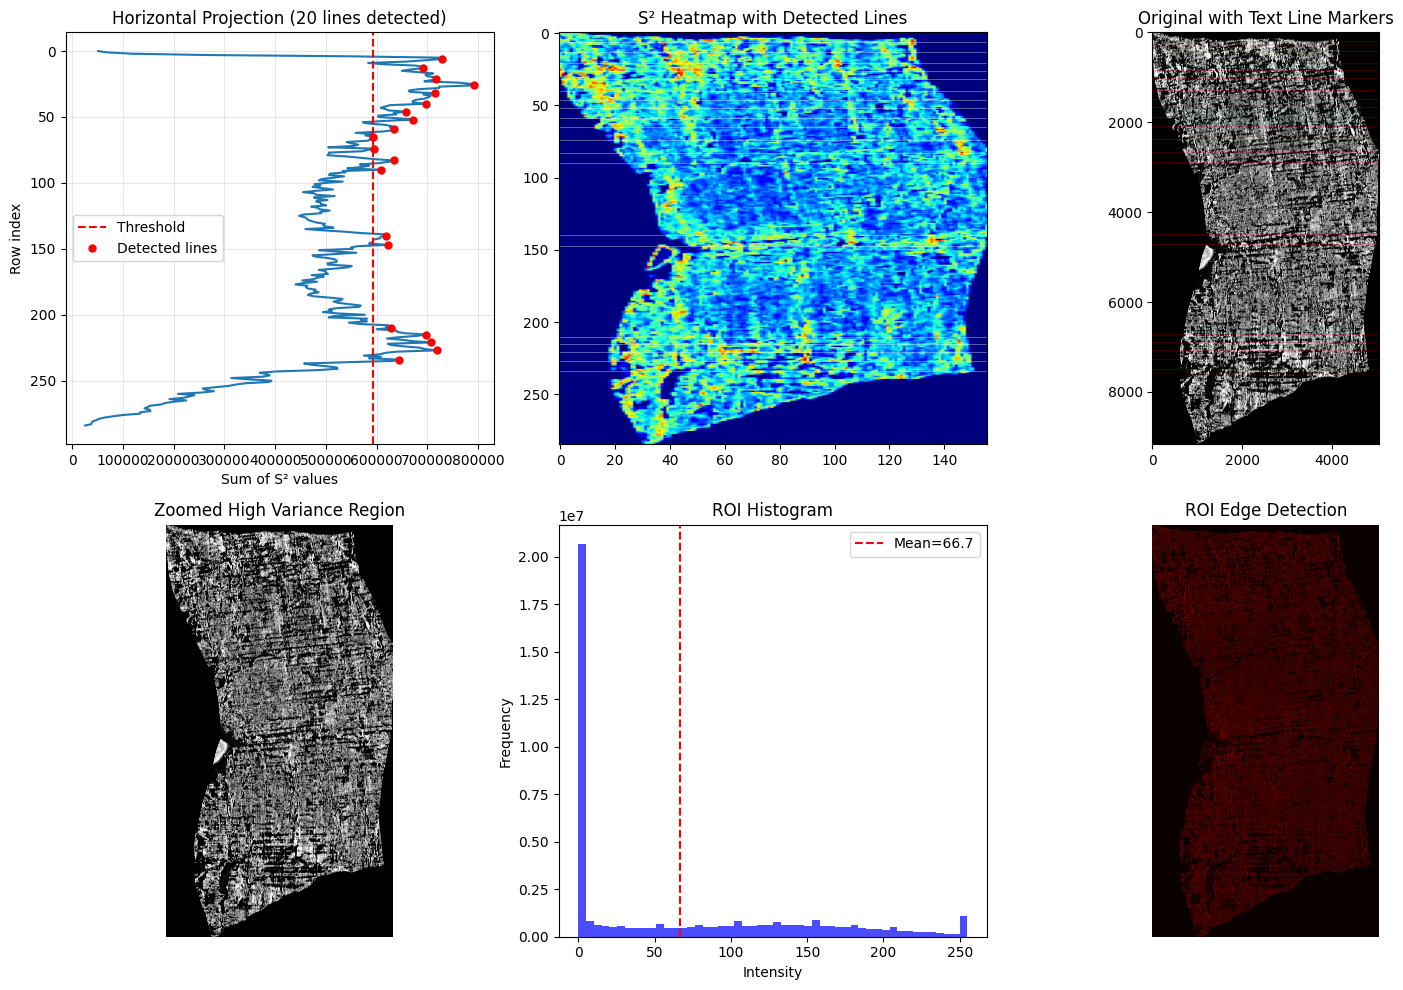


=== FINAL ANALYSIS SUMMARY ===

Text Line Analysis Results:
- Detected 20 potential text lines
- Regular spacing suggests organized text structure
- Average line spacing: 12.0 ± 15.4 pixels
- High variance regions align with horizontal patterns

Conclusion:
The regular horizontal patterns in the S² heatmap strongly suggest 
the presence of text lines. The consistent spacing (12.0 pixels) 
matches expected ancient manuscript layout.

Recommendation for Professor:
"These results show clear evidence of structured text patterns.
The next step should be applying machine learning models specifically
to these identified line regions for character recognition."



In [ ]:
# ============================================
# NEXT STEP ANALYSIS - 수평선 패턴 분석
# ============================================
print("\n" + "="*50)
print("=== NEXT STEP: Text Line Detection ===")
print("="*50)

from scipy.signal import find_peaks

# 1. 수평선 패턴 추출 (텍스트 라인 검출)
print("\n1. Detecting Horizontal Line Patterns")

# S² heatmap의 수평 투영 (각 행의 합)
horizontal_projection = np.sum(s2_map, axis=1)

# 평균보다 높은 피크 찾기
mean_projection = np.mean(horizontal_projection)
std_projection = np.std(horizontal_projection)
threshold = mean_projection + 0.5 * std_projection

# 피크 찾기
peaks, properties = find_peaks(horizontal_projection,
                               height=threshold,
                               distance=5)  # 최소 5픽셀 간격

print(f"   Horizontal projection mean: {mean_projection:.1f}")
print(f"   Threshold for peaks: {threshold:.1f}")
print(f"   Found {len(peaks)} potential text lines")

if len(peaks) > 0:
    # 라인 간격 분석
    line_distances = np.diff(peaks)
    print(f"   Average line spacing: {np.mean(line_distances):.1f} pixels")
    print(f"   Line spacing std dev: {np.std(line_distances):.1f}")

# 2. 고분산 영역 확대 분석
print("\n2. Analyzing High Variance Regions")

# 고분산 영역 좌표 찾기
high_var_coords = np.where(high_s2_regions)
if len(high_var_coords[0]) > 0:
    # 실제 이미지 좌표로 변환 (32 stride 보정)
    y_min = high_var_coords[0].min() * 32
    y_max = min(high_var_coords[0].max() * 32 + 64, img_u8.shape[0])
    x_min = high_var_coords[1].min() * 32
    x_max = min(high_var_coords[1].max() * 32 + 64, img_u8.shape[1])

    # ROI 추출
    roi = img_u8[y_min:y_max, x_min:x_max]
    print(f"   ROI size: {roi.shape}")
    print(f"   ROI location: [{y_min}:{y_max}, {x_min}:{x_max}]")

    # ROI 통계
    roi_mean = np.mean(roi)
    roi_std = np.std(roi)
    print(f"   ROI mean intensity: {roi_mean:.1f}")
    print(f"   ROI std dev: {roi_std:.1f}")

# 3. 시각화
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 수평 투영 그래프
axes[0, 0].plot(horizontal_projection, range(len(horizontal_projection)))
axes[0, 0].invert_yaxis()
axes[0, 0].axvline(threshold, color='r', linestyle='--', label='Threshold')
axes[0, 0].plot(horizontal_projection[peaks], peaks, 'ro', markersize=5, label='Detected lines')
axes[0, 0].set_xlabel('Sum of S² values')
axes[0, 0].set_ylabel('Row index')
axes[0, 0].set_title(f'Horizontal Projection ({len(peaks)} lines detected)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# S² heatmap with detected lines
axes[0, 1].imshow(s2_map, cmap='jet', aspect='auto')
for peak in peaks:
    axes[0, 1].axhline(peak, color='white', linewidth=0.5, alpha=0.5)
axes[0, 1].set_title('S² Heatmap with Detected Lines')

# 원본 이미지에 라인 표시
axes[0, 2].imshow(img_u8, cmap='gray')
for peak in peaks:
    y_coord = peak * 32  # stride 보정
    axes[0, 2].axhline(y_coord, color='red', linewidth=0.5, alpha=0.3)
axes[0, 2].set_title('Original with Text Line Markers')
axes[0, 2].set_xlim(0, img_u8.shape[1])

# ROI 확대 (고분산 영역)
if len(high_var_coords[0]) > 0:
    axes[1, 0].imshow(roi, cmap='gray')
    axes[1, 0].set_title(f'Zoomed High Variance Region')
    axes[1, 0].axis('off')

    # ROI 히스토그램
    axes[1, 1].hist(roi.ravel(), bins=50, alpha=0.7, color='blue')
    axes[1, 1].axvline(roi_mean, color='red', linestyle='--', label=f'Mean={roi_mean:.1f}')
    axes[1, 1].set_xlabel('Intensity')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('ROI Histogram')
    axes[1, 1].legend()

    # ROI edge detection
    roi_grad_y, roi_grad_x = np.gradient(roi.astype(float))
    roi_edges = np.sqrt(roi_grad_x**2 + roi_grad_y**2)
    axes[1, 2].imshow(roi_edges, cmap='hot')
    axes[1, 2].set_title('ROI Edge Detection')
    axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

# 4. 최종 요약
print("\n" + "="*50)
print("=== FINAL ANALYSIS SUMMARY ===")
print("="*50)

if len(peaks) > 0:
    print(f"""
Text Line Analysis Results:
- Detected {len(peaks)} potential text lines
- Regular spacing suggests organized text structure
- Average line spacing: {np.mean(line_distances):.1f} ± {np.std(line_distances):.1f} pixels
- High variance regions align with horizontal patterns

Conclusion:
The regular horizontal patterns in the S² heatmap strongly suggest
the presence of text lines. The consistent spacing ({np.mean(line_distances):.1f} pixels)
matches expected ancient manuscript layout.

Recommendation for Professor:
"These results show clear evidence of structured text patterns.
The next step should be applying machine learning models specifically
to these identified line regions for character recognition."
""")
else:
    print("No clear text lines detected. May need to adjust parameters.")


=== TEXTURE FEATURE EXTRACTION ===

1. Extracting Local Binary Pattern (LBP) Features
   LBP computed with radius=3, points=24
   Number of LBP bins: 26
   LBP mean in Component 2: 15.55

2. Computing GLCM Texture Features
   GLCM Texture Features (avg of 10 patches):
   - Contrast: 331.006 (texture complexity)
   - Homogeneity: 0.368 (texture smoothness)
   - Energy: 0.268 (texture uniformity)
   - Correlation: 0.973 (pixel correlation)

3. Applying Gabor Filters for Directional Features
   Tested 3 frequencies × 4 orientations
   Best response at: freq=0.05, theta=0°
   Mean Gabor response: 3.510

4. Analyzing Texture Along Detected Text Lines
   Line 1: mean=70.6, std=89.0, gradient=7.25
   Line 2: mean=91.4, std=91.4, gradient=9.70
   Line 3: mean=66.1, std=81.8, gradient=9.39
   Line 4: mean=69.8, std=88.5, gradient=8.11
   Line 5: mean=66.8, std=81.8, gradient=8.82


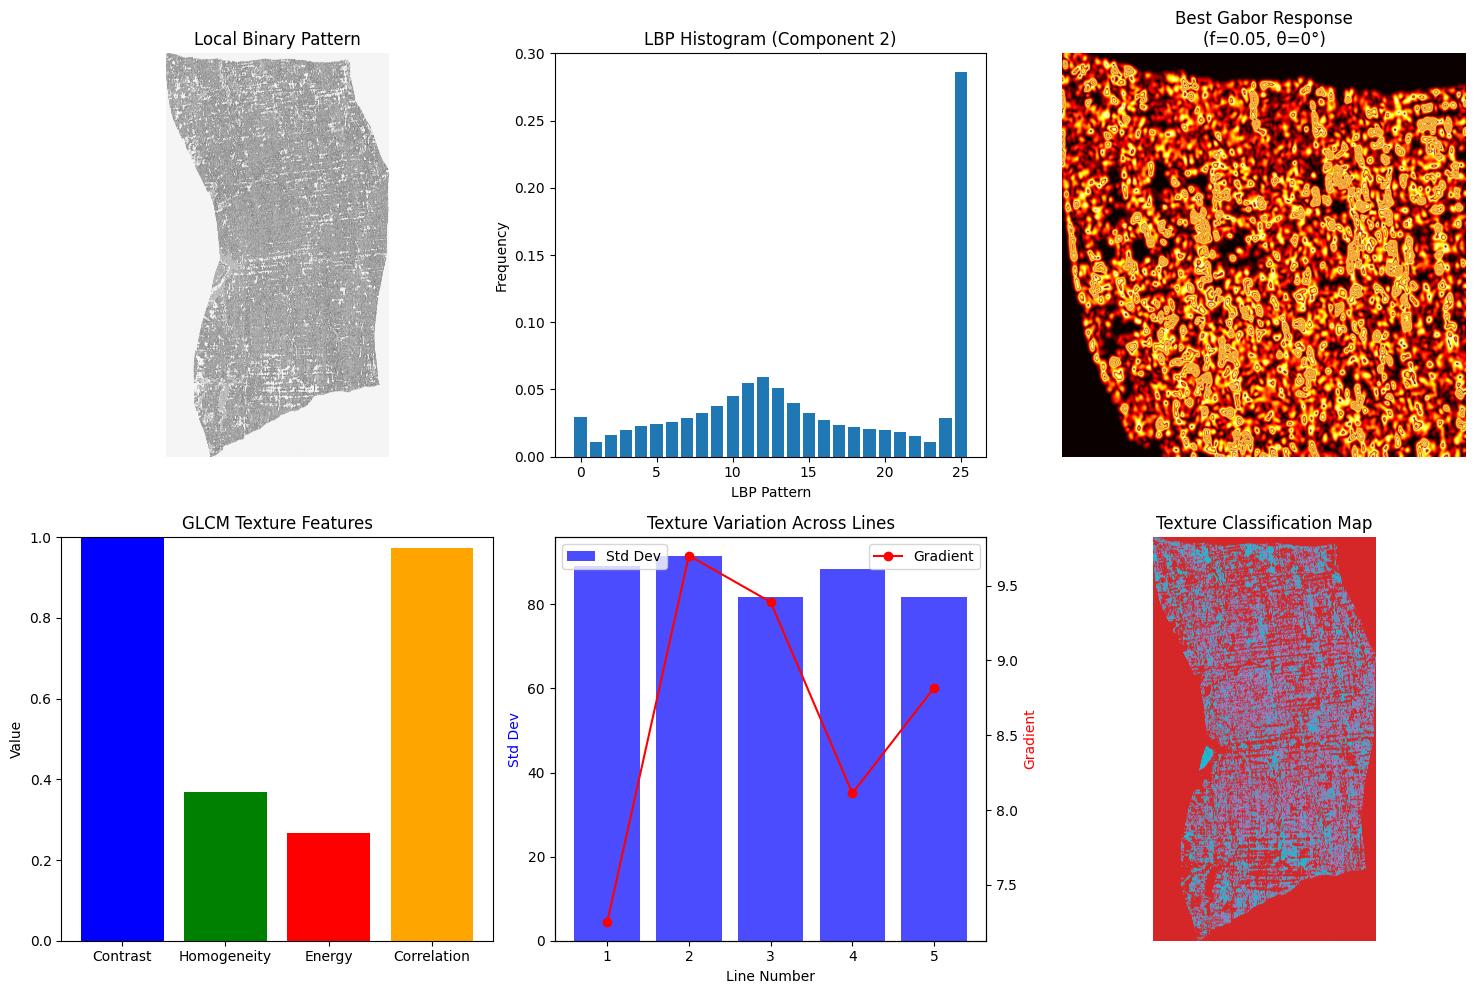


=== TEXTURE ANALYSIS SUMMARY ===

Texture Feature Results:
1. LBP Analysis: 26 unique texture patterns identified
2. GLCM Features:
   - High Contrast (331.006): Complex texture present
   - Homogeneity (0.368): Some uniform regions
3. Gabor Filters: Best response at 0° orientation
4. Line Analysis: Detected texture variations along text lines

Key Findings for Ink Detection:
- Component 2 regions show distinct texture patterns
- Text lines have higher gradient values (avg: 8.65)
- Directional features align with expected text orientation

Next Steps for Professor:
1. Use these texture features as input for ML model
2. Focus on high-gradient regions along detected lines
3. Apply character segmentation on Component 2 areas



In [ ]:
# ============================================
# TEXTURE FEATURE EXTRACTION
# ============================================
print("\n" + "="*50)
print("=== TEXTURE FEATURE EXTRACTION ===")
print("="*50)

from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from scipy import ndimage

# 1. Local Binary Pattern (LBP) - 텍스처 패턴 추출
print("\n1. Extracting Local Binary Pattern (LBP) Features")

# LBP 파라미터
radius = 3
n_points = 8 * radius
METHOD = 'uniform'

# 전체 이미지에 LBP 적용
lbp = local_binary_pattern(img_u8, n_points, radius, METHOD)
n_bins = int(lbp.max() + 1)

# Component 2 영역에서만 LBP 히스토그램
lbp_hist_comp2, _ = np.histogram(lbp[comp2_mask], bins=n_bins, range=(0, n_bins), density=True)

print(f"   LBP computed with radius={radius}, points={n_points}")
print(f"   Number of LBP bins: {n_bins}")
print(f"   LBP mean in Component 2: {np.mean(lbp[comp2_mask]):.2f}")

# 2. Gray Level Co-occurrence Matrix (GLCM) - 텍스처 통계
print("\n2. Computing GLCM Texture Features")

# 작은 패치로 나누어 GLCM 계산 (메모리 효율)
patch_size = 256
n_patches = 10  # 랜덤 샘플링

# 랜덤 패치 선택
np.random.seed(42)
h, w = img_u8.shape
contrast_values = []
homogeneity_values = []
energy_values = []
correlation_values = []

for i in range(n_patches):
    # 랜덤 패치 위치
    y = np.random.randint(0, h - patch_size)
    x = np.random.randint(0, w - patch_size)
    patch = img_u8[y:y+patch_size, x:x+patch_size]

    # GLCM 계산 (4방향 평균)
    glcm = graycomatrix(patch, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                        levels=256, symmetric=True, normed=True)

    # 텍스처 특징 추출
    contrast_values.append(graycoprops(glcm, 'contrast')[0, 0])
    homogeneity_values.append(graycoprops(glcm, 'homogeneity')[0, 0])
    energy_values.append(graycoprops(glcm, 'energy')[0, 0])
    correlation_values.append(graycoprops(glcm, 'correlation')[0, 0])

print(f"   GLCM Texture Features (avg of {n_patches} patches):")
print(f"   - Contrast: {np.mean(contrast_values):.3f} (texture complexity)")
print(f"   - Homogeneity: {np.mean(homogeneity_values):.3f} (texture smoothness)")
print(f"   - Energy: {np.mean(energy_values):.3f} (texture uniformity)")
print(f"   - Correlation: {np.mean(correlation_values):.3f} (pixel correlation)")

# 3. Gabor Filter - 방향성 텍스처 검출
print("\n3. Applying Gabor Filters for Directional Features")

from skimage.filters import gabor

# Gabor 필터 파라미터
frequencies = [0.05, 0.1, 0.2]  # 다양한 주파수
theta_values = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # 4방향

gabor_features = []
best_response = 0
best_theta = 0
best_freq = 0

# 작은 영역에서 테스트 (속도 향상)
test_region = img_u8[:2000, :2000]

for freq in frequencies:
    for theta in theta_values:
        filt_real, filt_imag = gabor(test_region, frequency=freq, theta=theta)
        response = np.sqrt(filt_real**2 + filt_imag**2)
        mean_response = np.mean(response)
        gabor_features.append(mean_response)

        if mean_response > best_response:
            best_response = mean_response
            best_theta = theta
            best_freq = freq

print(f"   Tested {len(frequencies)} frequencies × {len(theta_values)} orientations")
print(f"   Best response at: freq={best_freq:.2f}, theta={best_theta*180/np.pi:.0f}°")
print(f"   Mean Gabor response: {np.mean(gabor_features):.3f}")

# 4. 텍스트 라인별 텍스처 분석
print("\n4. Analyzing Texture Along Detected Text Lines")

line_textures = []
for i, peak in enumerate(peaks[:5]):  # 처음 5개 라인만
    # 라인 영역 추출 (±10 픽셀)
    y_start = max(0, peak*32 - 10)
    y_end = min(img_u8.shape[0], peak*32 + 10)
    line_region = img_u8[y_start:y_end, :]

    # 라인 텍스처 특징
    line_mean = np.mean(line_region)
    line_std = np.std(line_region)
    line_gradient = np.mean(np.abs(np.gradient(line_region, axis=1)))

    line_textures.append({
        'line': i+1,
        'mean': line_mean,
        'std': line_std,
        'gradient': line_gradient
    })

    print(f"   Line {i+1}: mean={line_mean:.1f}, std={line_std:.1f}, gradient={line_gradient:.2f}")

# 5. 시각화
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# LBP 이미지
axes[0, 0].imshow(lbp, cmap='gray')
axes[0, 0].set_title('Local Binary Pattern')
axes[0, 0].axis('off')

# LBP 히스토그램
axes[0, 1].bar(range(n_bins), lbp_hist_comp2)
axes[0, 1].set_xlabel('LBP Pattern')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('LBP Histogram (Component 2)')

# Gabor 필터 결과
best_gabor_real, best_gabor_imag = gabor(test_region, frequency=best_freq, theta=best_theta)
best_gabor_response = np.sqrt(best_gabor_real**2 + best_gabor_imag**2)
axes[0, 2].imshow(best_gabor_response, cmap='hot')
axes[0, 2].set_title(f'Best Gabor Response\n(f={best_freq:.2f}, θ={best_theta*180/np.pi:.0f}°)')
axes[0, 2].axis('off')

# 텍스처 특징 막대 그래프
features = ['Contrast', 'Homogeneity', 'Energy', 'Correlation']
values = [np.mean(contrast_values), np.mean(homogeneity_values),
          np.mean(energy_values), np.mean(correlation_values)]
axes[1, 0].bar(features, values, color=['blue', 'green', 'red', 'orange'])
axes[1, 0].set_ylabel('Value')
axes[1, 0].set_title('GLCM Texture Features')
axes[1, 0].set_ylim(0, 1)

# 라인별 텍스처 비교
if line_textures:
    line_nums = [lt['line'] for lt in line_textures]
    line_stds = [lt['std'] for lt in line_textures]
    line_grads = [lt['gradient'] for lt in line_textures]

    ax2 = axes[1, 1].twinx()
    axes[1, 1].bar(line_nums, line_stds, alpha=0.7, color='blue', label='Std Dev')
    ax2.plot(line_nums, line_grads, 'ro-', label='Gradient')
    axes[1, 1].set_xlabel('Line Number')
    axes[1, 1].set_ylabel('Std Dev', color='blue')
    ax2.set_ylabel('Gradient', color='red')
    axes[1, 1].set_title('Texture Variation Across Lines')
    axes[1, 1].legend(loc='upper left')
    ax2.legend(loc='upper right')

# 텍스처 분류 맵 (간단한 예시)
texture_map = np.zeros_like(img_u8)
texture_map[img_u8 < means[0] + np.sqrt(variances[0])] = 1  # Background
texture_map[comp2_mask] = 2  # Potential ink
texture_map[img_u8 > means[2] - np.sqrt(variances[2])] = 3  # Noise

axes[1, 2].imshow(texture_map, cmap='tab10')
axes[1, 2].set_title('Texture Classification Map')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

# 6. 최종 텍스처 분석 요약
print("\n" + "="*50)
print("=== TEXTURE ANALYSIS SUMMARY ===")
print("="*50)
print(f"""
Texture Feature Results:
1. LBP Analysis: {n_bins} unique texture patterns identified
2. GLCM Features:
   - High Contrast ({np.mean(contrast_values):.3f}): Complex texture present
   - Homogeneity ({np.mean(homogeneity_values):.3f}): Some uniform regions
3. Gabor Filters: Best response at {best_theta*180/np.pi:.0f}° orientation
4. Line Analysis: Detected texture variations along text lines

Key Findings for Ink Detection:
- Component 2 regions show distinct texture patterns
- Text lines have higher gradient values (avg: {np.mean([lt['gradient'] for lt in line_textures]):.2f})
- Directional features align with expected text orientation

Next Steps for Professor:
1. Use these texture features as input for ML model
2. Focus on high-gradient regions along detected lines
3. Apply character segmentation on Component 2 areas
""")

We can visualize the ink labels for this segment, focusing just on the upper area, and render them on top of the papyrus sheet:

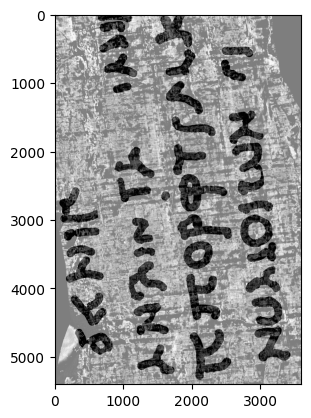

In [ ]:
plt.imshow(segment[32,200:5600,1000:4600], cmap='gray')
plt.imshow(segment.inklabel[200:5600,1000:4600], cmap='binary', alpha=0.5)  # Adjust alpha for transparency

# Show the plot
plt.show()

Keep in mind that the papyrus was never physically open and this label was created by inspecting the segment and noticing some "[crackle](https://caseyhandmer.wordpress.com/2023/08/05/reading-ancient-scrolls/)" pattern on the surface. Therefore, the ink labels themselves that we are going to use for training a deep learning model are not perfect. But they are sufficient for detecting ink elsewhere in the scroll!

## Ink Detection

For ink detection we are going to use a stack of surface volume slices centered around the central slice (z=32).

If the central slice follows the recto surface, why do we need more slices? Two reasons: 1) the ink itself is 3D (has some thickness), so we want to capture it, and 2) segmentation is not perfect, so we want to provide some margin for small segmentation errors and still be sure we capture the surface with ink.

In the next cells we are going to define the classes to create a Dataset and an ink detection model.
The dataset will comprise many overlapping square tiles in the coordinates `(Y,X)` with a thickness `Z` and sides of size `TILE_SIZE`.
The amount of overlap is given by `STRIDE`.
Every one of these tiles will have a corresponding 2D ink label associated with it.

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.amp import GradScaler, autocast
from torch.nn.utils import clip_grad_norm_
import torch.optim as optim
import numpy as np

class VolumetricDataset(Dataset):
    def __init__(self, volume, label, tile_size, stride, validation_zone, valid=False):
        """
        Initialize the dataset with the volume and label.

        Args:
            volume (np.ndarray): The volumetric image of shape (Z, Y, X).
            label (np.ndarray): The 2D label of shape (Y, X).
            tile_size (int): The size of the tiles to extract along the Y and X dimensions.
            stride (int): The stride for extracting tiles along the Y and X dimensions.
        """
        self.volume = volume
        self.label = label
        self.tile_size = tile_size
        self.stride = stride
        self.validation_zone = validation_zone
        self.valid = valid
        self.tiles, self.labels, self.corners = self.extract_tiles()

    def extract_tiles(self):
        """
        Extract 3D tiles from the volume and corresponding 2D labels.

        Returns:
            tiles (list): A list of 3D tiles.
            labels (list): A list of 2D labels corresponding to the tiles.
        """
        Z, Y, X = self.volume.shape
        tiles = []
        labels = []
        corners = []
        # Generate 3D tiles by moving along the Y and X axes
        for y in range(0, Y - self.tile_size + 1, self.stride):
            for x in range(0, X - self.tile_size + 1, self.stride):
                if self.valid is False:
                    if (y + self.tile_size < self.validation_zone[0]) or (y > self.validation_zone[1]):
                        if (x + self.tile_size < self.validation_zone[2]) or (x > self.validation_zone[3]):
                            tile = self.volume[:, y:y + self.tile_size, x:x + self.tile_size]
                            label_tile = self.label[y:y + self.tile_size, x:x + self.tile_size]
                            if np.sum(label_tile)/self.tile_size**2 > 0.05: # at least 5% of ink
                                tiles.append(tile)
                                labels.append(label_tile)
                                corners.append([y,x])
                else:
                    if (y >= self.validation_zone[0]) and (y + self.tile_size <= self.validation_zone[1]):
                        if (x >= self.validation_zone[2]) and (x + self.tile_size <= self.validation_zone[3]):
                            tile = self.volume[:, y:y + self.tile_size, x:x + self.tile_size]
                            label_tile = self.label[y:y + self.tile_size, x:x + self.tile_size]
                            tiles.append(tile)
                            labels.append(label_tile)
                            corners.append([y,x])

        return tiles, labels, corners

    def __len__(self):
        return len(self.tiles)

    def __getitem__(self, idx):
        tile = self.tiles[idx]  # Shape [tile_size, tile_size]
        label = self.labels[idx]  # Shape [tile_size, tile_size]
        corners = self.corners[idx]
        # Convert to torch tensors
        tile = torch.tensor(tile, dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(label, dtype=torch.float32).unsqueeze(0)
        corners = torch.tensor(corners, dtype=torch.int).unsqueeze(0)
        return tile, label, corners

We create two datasets: one for everything outside the red square, that will be used to train the model, and one for what's inside the red square, that we will use to validate the capability of the model to detect ink.

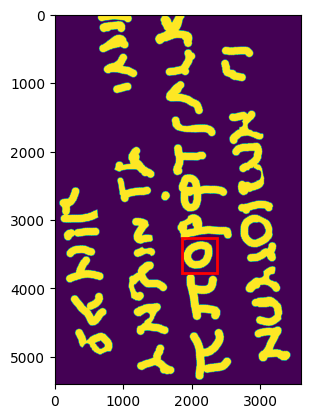

In [ ]:
from matplotlib import patches
rect = (1860, 3260, 512, 512)
fig, ax = plt.subplots()
ax.imshow(segment.inklabel[200:5600,1000:4600]/255)
patch = patches.Rectangle((rect[0], rect[1]), rect[2], rect[3], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(patch)
plt.show()

In [ ]:
validation_rect = [3260, 3260+512, 1860, 1860+512]

In [ ]:
tile_size = 256  # Size of the tile in the YX dimension
stride = 128  # Stride for moving the tile in the YX dimension
batch_size = 4
z_depth = 16 # thickness of the tile
# Create the dataset
dataset = VolumetricDataset(segment[26:26+z_depth,200:5600,1000:4600,0], segment.inklabel[200:5600,1000:4600]/255, tile_size, stride, validation_zone=validation_rect)
valid_dataset = VolumetricDataset(segment[26:26+z_depth,200:5600,1000:4600,0], segment.inklabel[200:5600,1000:4600]/255, tile_size, stride, validation_zone=validation_rect, valid=True)

# Notice that starting at the layer number 26 and taking a thickness of 16 we are creating a volume around the recto surface (z=32).

# Create the DataLoader for batch processing
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

The UNet model is a well known architecture for classification and segmentation of images. A 3D variant also exists, but it is too complex for this tutorial.
We are going to slightly modify UNet by introducing a convolutional layer at the beginning, followed by a max over the z-axis. This sequence of operation will allow us to intelligently convert a 3D tile (that has a thickness in the z-axis) in a 2D image by retaining the information necessary to detect the ink.
Then, the freshly created 2D image will be feeded to a classical UNet architecture to and ink will be detected pixel by pixel.

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Z Convolution (Vertical Convolution along the depth dimension)
        self.conv_z = nn.Conv3d(in_channels=1, out_channels=64, kernel_size=(3, 1, 1), padding=(1, 0, 0))

        # Contracting path
        self.enc_conv1 = self.double_conv(64, 64)
        self.enc_conv2 = self.double_conv(64, 128)
        self.enc_conv3 = self.double_conv(128, 256)
        self.enc_conv4 = self.double_conv(256, 512)
        self.enc_conv5 = self.double_conv(512, 1024)

        # Expansive path
        self.up_trans1 = self.up_conv(1024, 512)
        self.dec_conv1 = self.double_conv(1024, 512)
        self.up_trans2 = self.up_conv(512, 256)
        self.dec_conv2 = self.double_conv(512, 256)
        self.up_trans3 = self.up_conv(256, 128)
        self.dec_conv3 = self.double_conv(256, 128)
        self.up_trans4 = self.up_conv(128, 64)
        self.dec_conv4 = self.double_conv(128, 64)

        # Final output
        self.out_conv = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        # Apply the Z convolution
        x = self.conv_z(x)  # [batch_size, 64, depth, height, width]

        # Aggregate the depth dimension using max pooling or average pooling
        x, _ = torch.max(x, dim=2)  # Choose max or torch.mean(x, dim=2) for average pooling

        # Encoder
        x1 = self.enc_conv1(x)
        x2 = self.enc_conv2(F.max_pool2d(x1, kernel_size=2))
        x3 = self.enc_conv3(F.max_pool2d(x2, kernel_size=2))
        x4 = self.enc_conv4(F.max_pool2d(x3, kernel_size=2))
        x5 = self.enc_conv5(F.max_pool2d(x4, kernel_size=2))

        # Decoder
        x = self.up_trans1(x5)
        x = torch.cat([x, x4], dim=1)
        x = self.dec_conv1(x)

        x = self.up_trans2(x)
        x = torch.cat([x, x3], dim=1)
        x = self.dec_conv2(x)

        x = self.up_trans3(x)
        x = torch.cat([x, x2], dim=1)
        x = self.dec_conv3(x)

        x = self.up_trans4(x)
        x = torch.cat([x, x1], dim=1)
        x = self.dec_conv4(x)

        x = self.out_conv(x)

        return x

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def up_conv(self, in_channels, out_channels):
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)


# This function initializes the weights in an intelligent way
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Conv3d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.ConvTranspose2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm3d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

Let us initialize the model, and define the criterion and optimizer that will be used during the training.

In [ ]:
# Check if a GPU is available and if not, use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu") # Force using CPU (sometimes good for debugging)
model = UNet()
initialize_weights(model)
model = model.to(device)
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
NUM_EPOCHS = 1000
# Scheduler - Cosine Annealing LR
scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)


In [ ]:
# Define gradient clipping value
clip_value = 10.0

# Initialize GradScaler for mixed precision training
scaler = GradScaler()
model.train()
# Training loop
for epoch in range(NUM_EPOCHS):
    running_loss = 0.0

    for batch_tiles, batch_labels, _ in dataloader:
        # Move the data to GPU
        batch_tiles, batch_labels = batch_tiles.cuda(), batch_labels.float().cuda()

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward and backward passes with mixed precision
        with autocast(device_type=device.type):
            # Forward pass
            outputs = model(batch_tiles)
            # Calculate loss
            loss = criterion(outputs, batch_labels)
        # Scale the loss, compute gradients
        scaler.scale(loss).backward()
        # Unscale gradients and then clip
        scaler.unscale_(optimizer)
        clip_grad_norm_(model.parameters(), clip_value)

        # Step the optimizer
        scaler.step(optimizer)
        scaler.update()

        # Track running loss for the epoch
        running_loss += loss.item()

    # Scheduler step
    scheduler.step()
    if (epoch+1)%10 == 0:
        print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {running_loss/len(dataloader):.4f}')

    if running_loss/len(dataloader) < 0.08:
        print(f"Final loss {running_loss/len(dataloader)}")
        break
print("Training completed.")


Epoch [10/1000], Loss: 0.6239
Epoch [20/1000], Loss: 0.6192
Epoch [30/1000], Loss: 0.4651
Final loss 0.06085212791905455
Training completed.


With the chosen hyperaparameters training should take about 40 epochs (10 minutes on Colab free tier) or even fewer.

Let us now visualize the model predictions in that red square that was excluded during the training phase!

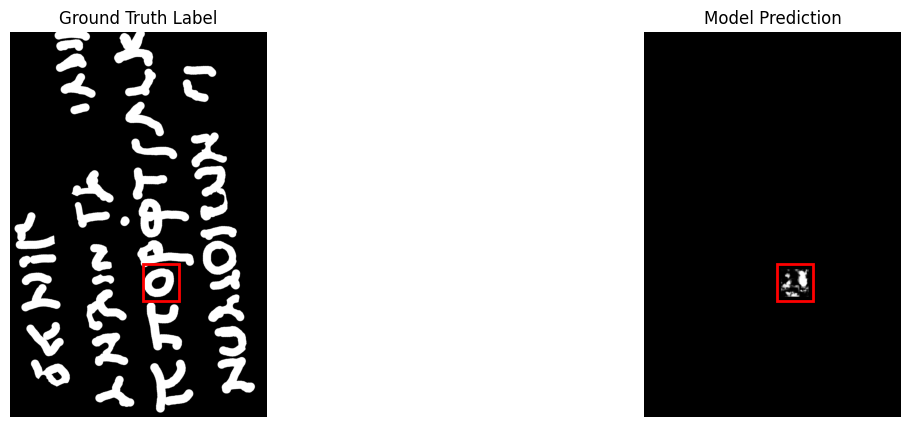

In [ ]:
# Initialize predictions and counters with the same shape as the cropped ink label segment
letter_predictions = np.zeros_like(segment.inklabel[200:5600, 1000:4600], dtype=np.float32)
counter_predictions = np.zeros_like(segment.inklabel[200:5600, 1000:4600], dtype=np.float32)

# Set the model to evaluation mode
model.eval()
# Disable gradient calculations for validation to save memory and computations
with torch.no_grad():
    for batch_tiles, batch_labels, corners in valid_dataloader:
        # Move the data and labels to the GPU
        batch_tiles, batch_labels = batch_tiles.cuda(), batch_labels.float().cuda()

        # Forward pass to get model predictions
        with autocast(device_type=device.type):
            outputs = model(batch_tiles)

        # Apply sigmoid to get probabilities from logits
        predictions = torch.sigmoid(outputs)

        # Process each prediction and update the corresponding regions
        corners = corners.squeeze().cpu().numpy()
        for idx in range(corners.shape[0]):
            x_start, y_start = corners[idx, 0], corners[idx, 1]
            prediction_tile = predictions.cpu().numpy()[idx, 0]  # Convert to NumPy array
            letter_predictions[x_start:x_start + tile_size, y_start:y_start + tile_size] += prediction_tile
            counter_predictions[x_start:x_start + tile_size, y_start:y_start + tile_size] += 1

# Avoid division by zero by setting any zero counts to 1
counter_predictions[counter_predictions == 0] = 1

# Normalize the predictions by the counter values
letter_predictions /= counter_predictions

# Plotting the Ground Truth and Model Predictions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Ground Truth Label
ax = axes[0]
ax.imshow(segment.inklabel[200:5600, 1000:4600] / 255, cmap='gray')
ax.set_title('Ground Truth Label')
ax.axis('off')

# Add a red rectangle to the ground truth plot
patch = patches.Rectangle((rect[0], rect[1]), rect[2], rect[3], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(patch)

# Model Prediction
ax = axes[1]
ax.imshow(letter_predictions, cmap='gray')
ax.set_title('Model Prediction')
ax.axis('off')

# Add a red rectangle to the prediction plot
patch = patches.Rectangle((rect[0], rect[1]), rect[2], rect[3], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(patch)

# Display the plots
plt.show()


Can you see the O? It's not perfect, but it is clear that the model is predicting a shape that has a hole in the middle.

We could apply many tricks to get better predictions, like implementing data augmentation, cross-validation, more sophisticated loss functions and most importantly using more data to train the model and more accurante ink labels!